# NYC Taxi Rides to Hospital Prediction RNN 

Continue with the result we got from NYC Taxi analysis, I perform a time series prediction using a Recurrent Neural Network regressor. The particular network architecture I will employ for my RNN is a [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

## Pytorch LSTM Stock Predictor

This is a Pytorch version of the original Keras LSTM Stock Predictor provided by [Super DataScience](https://www.superdatascience.com/deep-learning/). I also rewrite the recursive procedure to make it able to predict further, future trends.

## Step 1: Loading the data

First let's load in our time series data - a record of percentage of taxi rides to hospitals in 78 consecutive months, or 6.5 years. We need to perform a number of pre-processing steps to prepare it for use with an RNN model. First off, it is good practice to normalize time series - by normalizing its range. This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [96]:
# Importing the data
dataset = data = pd.read_csv('temp_2009.csv')

In [97]:
dataset

,year,month,hospital
0,2009,1,0.019878
1,2009,2,0.019217
2,2009,3,0.019014
3,2009,4,0.018329
4,2009,5,0.018513
...,...,...,...
73,2015,2,0.019496
74,2015,3,0.019814
75,2015,4,0.019585
76,2015,5,0.018839


In [10]:
# zoom in the feature we want to predict
dataset_cl = dataset.hospital.values

In [11]:
dataset_cl

array([0.01987792, 0.01921697, 0.01901353, 0.01832919, 0.01851285,
       0.01917925, 0.01867577, 0.01810697, 0.01780972, 0.0180011 ,
       0.01781744, 0.01830101, 0.01848944, 0.01838601, 0.01879554,
       0.01820999, 0.01795274, 0.0181778 , 0.01799808, 0.01742721,
       0.01796813, 0.01747751, 0.0177223 , 0.01825113, 0.01882654,
       0.01815325, 0.01841923, 0.01774174, 0.01783436, 0.0179434 ,
       0.01754094, 0.01746623, 0.01713344, 0.01702532, 0.0174607 ,
       0.01701587, 0.01751045, 0.01734163, 0.01679438, 0.01676111,
       0.01690609, 0.01692555, 0.01709357, 0.01644628, 0.01604955,
       0.01656229, 0.01530831, 0.01525913, 0.01648431, 0.0161264 ,
       0.0161503 , 0.01732553, 0.01704019, 0.01732628, 0.01755177,
       0.01742882, 0.01691337, 0.01764212, 0.01745491, 0.01808399,
       0.0190925 , 0.01885095, 0.01858302, 0.01856777, 0.01805847,
       0.01785166, 0.01779721, 0.01816426, 0.01803641, 0.01845666,
       0.01828043, 0.01906609, 0.01953723, 0.01949588, 0.01981

In [98]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

# scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

## Step 2:  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 5 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above. For this project, we consider that a new point of data learns from the last 3 months, this can also be changed by re-slicing the data and updating the window size.

In [119]:
#Create a function to process the data into 3-month look back slices
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)
X, y = processData(dataset_cl, 6)


## Step 3: Split training and testing sets

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 80% of it), and validate on a later chunk (the last 20%) as this simulates how we would predict *future* values of a time series.

In [120]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

56
15
56
15


## Step 4:  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

In [121]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)
        
        return outs, hidden_state

In [122]:
# Globals

INPUT_SIZE = 6
HIDDEN_SIZE = 128
NUM_LAYERS = 2
OUTPUT_SIZE = 1
BATCH_SIZE = 32

# Hyper parameters

learning_rate = 0.01
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [152]:
rnn

RNN(
  (rnn): LSTM(3, 128, num_layers=2, dropout=0.1)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [123]:
# Training

history = []
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

# we use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state) 
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()               # set gradient to zero before bp
    loss.backward()                     # back propagation
    optimiser.step()                    # update the parameters
    
    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.296562135219574, eval loss 0.09721159189939499
epoch 1, loss 0.0396604910492897
epoch 2, loss 0.09106610715389252
epoch 3, loss 0.030751347541809082
epoch 4, loss 0.053762566298246384
epoch 5, loss 0.03280172869563103
epoch 6, loss 0.048691753298044205
epoch 7, loss 0.04321376606822014
epoch 8, loss 0.02957998402416706
epoch 9, loss 0.025094974786043167
epoch 10, loss 0.03500234708189964
epoch 11, loss 0.030163168907165527
epoch 12, loss 0.02371552772819996
epoch 13, loss 0.024276908487081528
epoch 14, loss 0.026306919753551483
epoch 15, loss 0.027111787348985672
epoch 16, loss 0.024520210921764374
epoch 17, loss 0.02017921209335327
epoch 18, loss 0.019768893718719482
epoch 19, loss 0.021232856437563896
epoch 20, loss 0.022112809121608734, eval loss 0.026313751935958862
epoch 21, loss 0.020453214645385742
epoch 22, loss 0.017514053732156754
epoch 23, loss 0.017905082553625107
epoch 24, loss 0.01862926222383976
epoch 25, loss 0.01787692867219448
epoch 26, loss 0.01633020

epoch 226, loss 0.004215072840452194
epoch 227, loss 0.0038166791200637817
epoch 228, loss 0.00365025969222188
epoch 229, loss 0.003775164717808366
epoch 230, loss 0.0031506777741014957
epoch 231, loss 0.003893121611326933
epoch 232, loss 0.003417958039790392
epoch 233, loss 0.0034103868529200554
epoch 234, loss 0.0037284744903445244
epoch 235, loss 0.0032315084245055914
epoch 236, loss 0.003376477863639593
epoch 237, loss 0.002787030301988125
epoch 238, loss 0.0033531344961375
epoch 239, loss 0.0034634824842214584
epoch 240, loss 0.0029635776299983263, eval loss 0.01675727777183056
epoch 241, loss 0.0031077491585165262
epoch 242, loss 0.0026451407466083765
epoch 243, loss 0.0028168964199721813
epoch 244, loss 0.002567139221355319
epoch 245, loss 0.0028925559017807245
epoch 246, loss 0.0025584229733794928
epoch 247, loss 0.0024620627518743277
epoch 248, loss 0.0029319303575903177
epoch 249, loss 0.0025008120574057102
epoch 250, loss 0.002812397899106145
epoch 251, loss 0.00278096226975

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

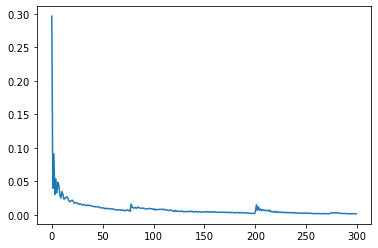

In [124]:
plt.plot(history)

In [155]:
X_test_cuda[0]

tensor([[0.6116, 0.8300, 0.7777]], device='cuda:0')

In [125]:
# X_train_X_test = np.concatenate((X_train, X_test),axis=0)
# hidden_state = None
rnn.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [157]:
test_predict_cpu.shape

(15, 1, 1)

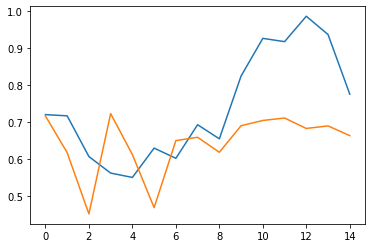

In [126]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))

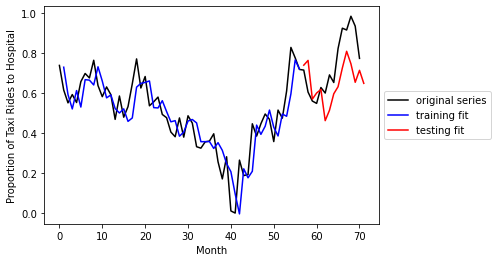

In [127]:
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 1# window_size
plt.plot(np.arange(1, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('Month')
plt.ylabel('Proportion of Taxi Rides to Hospital')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## Step 6: Prediction

Now we have done the model training, we can construct a convenient function to call when predicting for future values.

In [129]:
# deep copy the model
import copy 
rnn_test = copy.deepcopy(rnn)

In [130]:
# for predicting future values
def forecast(months, window, X, y, X_test, test_predict, test_predict_cpu, train_pred_cpu):
    
    # set local hyper-parameters
    CUR_SIZE = X.shape[0]
    INPUT_SIZE = window
    HIDDEN_SIZE = 128
    NUM_LAYERS = 2
    OUTPUT_SIZE = 1
    BATCH_SIZE = 64
    learning_rate = 0.01
    num_epochs = 300
    hidden_state = None
    
    # first, plot the original data with Black and training set with Blue
    plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')
    plt.plot(np.arange(0, X.shape[0], 1), 
             np.concatenate((sc.inverse_transform(train_pred_cpu.reshape(-1,1)),sc.inverse_transform(test_predict_cpu.reshape(-1,1))), 
             axis = 0), color='b')
    
    # concatenate trainig and testing results back together
    last_point = test_predict_cpu[-1]
    train_pred_cpu = np.concatenate((train_pred_cpu, test_predict_cpu), axis = 0)
    
    # begin iterating through the time frame we want to predict
    for i in range(months):
        rnn_test.eval()
        
        # this process glues the last predicted point to the training set, and uses as new training data to predict the next period
        t = X_test[-1]
        t = np.concatenate((X_test[-1][0][1:], test_predict[-1][0].cpu().detach().numpy())).reshape(1,1,window)
        X_test = np.concatenate((X_test[1:], t))
        X_test_cuda = torch.tensor(X_test).float().cuda()
        train_pred_cpu = np.concatenate((train_pred_cpu, test_predict[-1][0].cpu().detach().numpy().reshape(1,1,1)), axis = 0)
        test_predict, _ = rnn_test(X_test_cuda, hidden_state)
        test_predict_cpu = test_predict.cpu().detach().numpy()
        if i == 0:
            test_all = test_predict_cpu[-1]
        else:
            test_all = np.concatenate((test_all, test_predict_cpu[-1]))
        
        # re-train the model every 12 months, or cycles of other lengths
        if i > 0 and i % 12 == 0: 
            data = np.concatenate((sc.inverse_transform(train_pred_cpu.reshape(-1,1)),sc.inverse_transform(test_all.reshape(-1,1))))
            X, y = processData(data, window)

            X_train, X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
            y_train, y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
            X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
            X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

            X_test_cuda = torch.tensor(X_test).float().cuda()
            y_test_cuda = torch.tensor(y_test).float().cuda()
            inputs_cuda = torch.tensor(X_train).float().cuda()
            labels_cuda = torch.tensor(y_train).float().cuda()

            for epoch in range(num_epochs):
                rnn_test.train()
                output, _ = rnn_test(inputs_cuda, hidden_state) 

                loss = criterion(output[:,0,:].view(-1), labels_cuda)
                optimiser.zero_grad()               # set gradient to zero before bp
                loss.backward()                     # back propagation
                optimiser.step()                    # update the parameters
    
    # plot the prediction with Red
    test_all = np.concatenate((last_point, test_all))
    plt.plot(np.arange(CUR_SIZE - 1, CUR_SIZE + len(test_all) - 1, 1), sc.inverse_transform(test_all.reshape(-1,1)), color='r')
    plt.xlabel('Month')
    plt.ylabel('Proportion of Taxi Rides to Hospital')
    plt.legend(['original series','training fit','prediction'], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

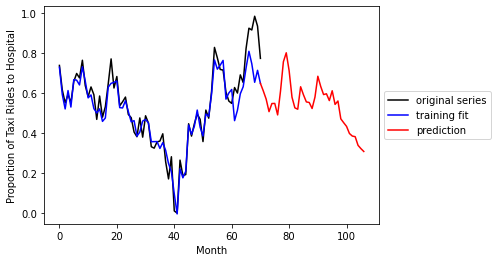

In [131]:
forecast(36, 6, X, y, X_test, test_predict, test_predict_cpu, train_pred_cpu) # ignore the warnings...

We have successfully predicted the trend in the next 36 months using an LSTM model.

Now we can apply the model on our second part of data.

In [150]:
# Importing the data
dataset2 = data = pd.read_csv('temp_2019.csv')

In [152]:
dataset2.head()

,year,month,hospital_zone
0,2017,1,0.151058
1,2017,2,0.151230
2,2017,3,0.147884
3,2017,4,0.150025
4,2017,5,0.147232


In [153]:
# zoom in the feature we want to predict
dataset2_cl = dataset2.hospital_zone.values

In [158]:
dataset.tail(40)

,year,month,hospital
38,2012,3,0.016794
39,2012,4,0.016761
40,2012,5,0.016906
41,2012,6,0.016926
42,2012,7,0.017094
43,2012,8,0.016446
44,2012,9,0.016050
45,2012,10,0.016562
46,2012,11,0.015308
47,2012,12,0.015259


In [136]:
# scaling
dataset2_cl = dataset2_cl.reshape(dataset2_cl.shape[0], 1)
dataset2_cl = sc.fit_transform(dataset2_cl)

In [139]:
# process the data using 3-month window
X, y = processData(dataset2_cl, 6)

In [140]:
# train-test split
X_train, X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train, y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

26
3
26
3


In [142]:
# Globals

INPUT_SIZE = 6
HIDDEN_SIZE = 128
NUM_LAYERS = 2
OUTPUT_SIZE = 1
BATCH_SIZE = 64

# Hyper parameters

learning_rate = 0.01
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [143]:
# Training

history = []
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

# we use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state) 
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()               # set gradient to zero before bp
    loss.backward(retain_graph=True)                     # back propagation
    optimiser.step()                    # update the parameters
    
    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.22516493499279022, eval loss 0.3475888669490814
epoch 1, loss 0.03307994082570076
epoch 2, loss 0.1198318749666214
epoch 3, loss 0.08285778760910034
epoch 4, loss 0.04040265083312988
epoch 5, loss 0.044459789991378784
epoch 6, loss 0.04790760949254036
epoch 7, loss 0.03305608406662941
epoch 8, loss 0.04042017459869385
epoch 9, loss 0.042799923568964005
epoch 10, loss 0.03703418746590614
epoch 11, loss 0.02924627624452114
epoch 12, loss 0.02999572642147541
epoch 13, loss 0.033368803560733795
epoch 14, loss 0.026594800874590874
epoch 15, loss 0.023687945678830147
epoch 16, loss 0.024147361516952515
epoch 17, loss 0.025549013167619705
epoch 18, loss 0.023073026910424232
epoch 19, loss 0.019566664472222328
epoch 20, loss 0.020672842860221863, eval loss 0.20810434222221375
epoch 21, loss 0.02025344781577587
epoch 22, loss 0.019216854125261307
epoch 23, loss 0.01763158291578293
epoch 24, loss 0.01922411099076271
epoch 25, loss 0.0189343374222517
epoch 26, loss 0.0170135907828

epoch 231, loss 0.00026469811564311385
epoch 232, loss 0.0005248974775895476
epoch 233, loss 0.0005354452878236771
epoch 234, loss 0.00034296646481379867
epoch 235, loss 0.0003705629787873477
epoch 236, loss 0.0004359866143204272
epoch 237, loss 0.0002510749618522823
epoch 238, loss 0.0005963536095805466
epoch 239, loss 0.0002300776686752215
epoch 240, loss 0.0008101669955067337, eval loss 0.3601096570491791
epoch 241, loss 0.00020911295723635703
epoch 242, loss 0.0003609979758039117
epoch 243, loss 0.00030484277522191405
epoch 244, loss 0.00023303288617171347
epoch 245, loss 0.0002035971701843664
epoch 246, loss 0.000343514111591503
epoch 247, loss 0.0002047187153948471
epoch 248, loss 0.00017438431677874178
epoch 249, loss 0.00032515014754608274
epoch 250, loss 0.00015757161600049585
epoch 251, loss 0.0001541184465168044
epoch 252, loss 0.00027546106139197946
epoch 253, loss 0.0003365555312484503
epoch 254, loss 0.00018357994849793613
epoch 255, loss 0.00019302306463941932
epoch 256,

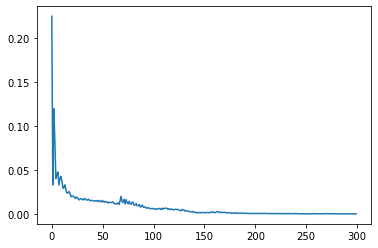

In [144]:
plt.plot(history)

In [145]:
rnn.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

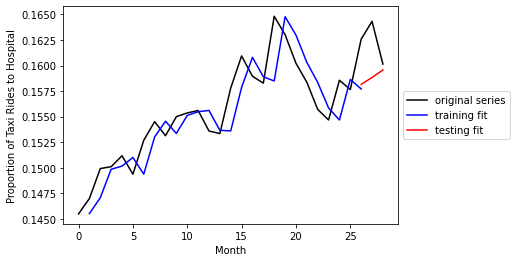

In [146]:
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.90) + 1# window_size
plt.plot(np.arange(1, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt - 1, split_pt + len(test_predict_cpu) - 1, 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('Month')
plt.ylabel('Proportion of Taxi Rides to Hospital')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [147]:
# deep copy the model
import copy 
rnn_test = copy.deepcopy(rnn)

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, po

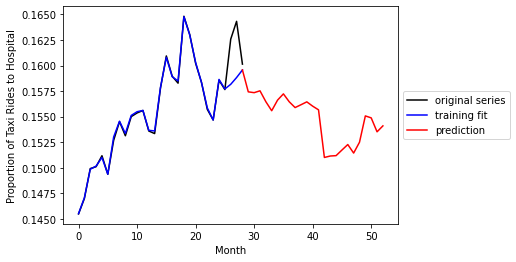

In [149]:
forecast(24, 6, X, y, X_test, test_predict, test_predict_cpu, train_pred_cpu)

We have successfully predicted the trend in the next 24 months using an LSTM model.